In [1]:
import os
import time

# math
import numpy as np
from numpy.random import default_rng, SeedSequence
import pathos.multiprocessing as mp

# data manipulation
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
def cranberry_passing_simulation(n_guests = 20, rng = default_rng()):
    '''
    Simulate cranberry passing process.
    
    Inputs:
      n_guests - number of guests at the table
      rng - random number generator, uses default_rng by default (:
    '''   
    
    # received_sauce is 1 if sauce has been received 0 otherwise
    received_sauce = np.zeros(n_guests, dtype='uint')
    
    # array whose i^th entry will be the i^th guest to receive 
    # the cranberry sauce
    received_order = np.zeros(n_guests, dtype='int')
    
    # initialize the problem
    current_position = 0
    received_sauce[current_position] = 1
    received_order[0] = 0
    n_received = 1
    n_passes = 0
    pos = [0]
    
    # iterate until everyone has received the cranberry sauce
    while n_received < n_guests:
        step = 2 * rng.integers(0, 1, endpoint =True) - 1
        
        current_position = (current_position + step) % n_guests
        pos.append(current_position)
        n_passes += 1
                
        if received_sauce[current_position] == 0:
            received_sauce[current_position] = 1
            received_order[n_received] = current_position
            n_received += 1
    
    received_last = received_order[-1]
        
    return received_last, n_passes

In [3]:
def repeat_cranberry_passing_simulation(n_guests = 20, n_simulations = 10, 
                                        rng = default_rng()):
    '''
    Repeat the cranberry passing simulation.
    
    Inputs:
      n_guests - number of guests at the table
      n_simulations - number of runs to simulate
      rng - random number generator, uses default_rng by default (:
    '''   
    
    # simulation results has an array with columns: received_last, n_passes
    sim_rslts = np.zeros((n_simulations, 2), dtype = 'int')
        
    # simulate
    for i in range(n_simulations):
        sim_rslts[i] = cranberry_passing_simulation(n_guests = n_guests, rng = rng)
    
    # add labels to columns
    sim_rslts = pd.DataFrame(sim_rslts, columns = ['received_last', 'n_passes'])
    
    return sim_rslts

In [4]:
def repeat_cranberry_passing_simulation_mp(n_guests = 20, n_simulations = 10, n_cores = 1, 
                                           seed = None):
    '''
    Multi-processing version of repeated cranberry passing simulation.
    
    Inputs:
      n_guests - number of guests at the table
      n_simulations - number of runs to simulate
      n_cores - number of multiprocessing threads to use 
      seed - random number generator seed, if none is provided, sets it randomly
    '''
    
    # produce a default seed if none ins provided
    if seed is None:
        seed = int(time.time())
    
    # set up rng to run in parallel reproducibly if seed was provided
    ss = SeedSequence(seed)
    child_seeds = ss.spawn(n_cores)
    streams = [default_rng(s) for s in child_seeds]
    
    # simulations per core
    n_sim_per_core = [n_simulations // n_cores for i in range(n_cores)]
    n_sim_per_core[0] = n_sim_per_core[0] + (n_simulations % n_cores)
    
    # perform the simulations on each core
    with mp.Pool(n_cores) as p:
        sim_rslts = p.map(
            lambda x: repeat_cranberry_passing_simulation(n_guests = n_guests, 
                                                          n_simulations = x[0], 
                                                          rng = x[1]), 
            zip(n_sim_per_core, streams)
        )
        
    # union all the result dataframes together
    sim_rslts = (pd.concat(sim_rslts, axis='rows')
                 .reset_index()
                 .drop(columns = ['index']))
            
    return sim_rslts

In [5]:
%%time
import time

n_simulations = int(1e6)
n_guests_lo = 2
n_guests_hi = 20

for n_guests in range(n_guests_lo, n_guests_hi + 1):
    tic = time.time()
    sim_rslts = repeat_cranberry_passing_simulation_mp(n_guests=n_guests, 
                                                       n_simulations = n_simulations, 
                                                       n_cores = 16, 
                                                       seed = 12345)
    
    # compute proabilities and conditional mean number of passes
    agg_rslts = sim_rslts.groupby('received_last').agg(['count', 'mean'])
    agg_rslts = agg_rslts.reset_index()
    agg_rslts.columns = ['_'.join(col).strip() for col in agg_rslts.columns.values]
    agg_rslts = agg_rslts.rename(
        columns = {'received_last_' : 'guest_number', 
                   'n_passes_count' : 'count', 
                   'n_passes_mean'  : 'mean_number_passes'}
    )
    agg_rslts['probability_last'] = agg_rslts['count'] / n_simulations
    agg_rslts['n_guests'] = n_guests
    agg_rslts = agg_rslts[['n_guests', 'guest_number', 'count', 'probability_last', 'mean_number_passes']]
    
    # compute unconditional mean number of passes and inefficiency    
    agg_rslts_uncond_mean = pd.DataFrame(sim_rslts[['n_passes']].mean())
    agg_rslts_uncond_mean.columns = ['mean_number_passes']
    agg_rslts_uncond_mean = agg_rslts_uncond_mean.reset_index(drop=True)
    agg_rslts_uncond_mean['n_guests'] = n_guests
    agg_rslts_uncond_mean = agg_rslts_uncond_mean[['n_guests', 'mean_number_passes']]
    agg_rslts_uncond_mean['inefficiency'] = (
        agg_rslts_uncond_mean['mean_number_passes'] / (agg_rslts_uncond_mean['n_guests'] - 1) - 1
    )
    
    toc = time.time()
    print("Simulation complete for n_guests = {} in {:0.02f} seconds.".format(n_guests, toc - tic))
    
    if n_guests == n_guests_lo:
        agg_rslts_all = agg_rslts
        agg_rslts_uncond_mean_all = agg_rslts_uncond_mean    
    else:
        agg_rslts_all = pd.concat([agg_rslts_all, agg_rslts])
        agg_rslts_uncond_mean_all = pd.concat([agg_rslts_uncond_mean_all, agg_rslts_uncond_mean])
        
# finalize indices
agg_rslts_all = agg_rslts_all.reset_index(drop=True)
agg_rslts_uncond_mean_all = agg_rslts_uncond_mean_all.reset_index(drop=True)

Simulation complete for n_guests = 2 in 1.01 seconds.
Simulation complete for n_guests = 3 in 1.70 seconds.
Simulation complete for n_guests = 4 in 2.51 seconds.
Simulation complete for n_guests = 5 in 4.01 seconds.
Simulation complete for n_guests = 6 in 5.31 seconds.
Simulation complete for n_guests = 7 in 8.01 seconds.
Simulation complete for n_guests = 8 in 9.51 seconds.
Simulation complete for n_guests = 9 in 12.02 seconds.
Simulation complete for n_guests = 10 in 15.02 seconds.
Simulation complete for n_guests = 11 in 18.13 seconds.
Simulation complete for n_guests = 12 in 21.64 seconds.
Simulation complete for n_guests = 13 in 25.54 seconds.
Simulation complete for n_guests = 14 in 29.65 seconds.
Simulation complete for n_guests = 15 in 34.05 seconds.
Simulation complete for n_guests = 16 in 39.26 seconds.
Simulation complete for n_guests = 17 in 44.07 seconds.
Simulation complete for n_guests = 18 in 49.57 seconds.
Simulation complete for n_guests = 19 in 55.08 seconds.
Simulat

In [6]:
# export simulation results
agg_rslts_all.to_csv('./output/simulation_prob_and_mean_passes_last.csv', index=False)
agg_rslts_uncond_mean_all.to_csv('./output/simulation_mean_passes_and_inefficiency.csv', index=False)

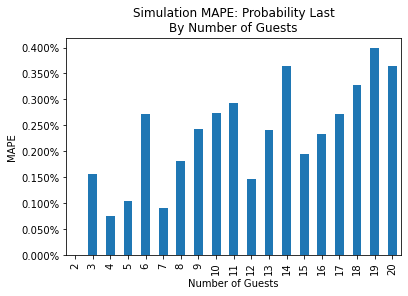

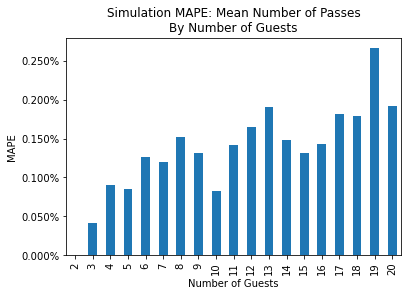

In [7]:
if os.path.exists('./output/analytical_prob_and_mean_passes_last.csv'):
    agg_analytical_all = pd.read_csv('./output/analytical_prob_and_mean_passes_last.csv')
    df_compare_all = pd.merge(
        agg_rslts_all,
        agg_analytical_all, 
        on = ['n_guests', 'guest_number'],
        how ='outer',
        suffixes=['_sim', '_theory']
    )
    
    df_compare_all['mean_number_passes_pct_error'] = (
        1 - df_compare_all['mean_number_passes_sim'] / df_compare_all['mean_number_passes_theory']
    )
    df_compare_all['probability_last_pct_error'] = (
        1 - df_compare_all['probability_last_sim'] / df_compare_all['probability_last_theory']
    )
    
    # write comparison to file
    df_compare_all.to_csv('./output/analytical_vs_sim_prob_and_mean_passes_last.csv')
    
    # add temporarily for computing MAPE. drop when done
    df_compare_all['abs_probability_last_pct_error'] = df_compare_all['probability_last_pct_error'].abs()
    df_compare_all['abs_mean_number_passes_pct_error'] = df_compare_all['mean_number_passes_pct_error'].abs()

    # compute MAPE
    df_compare_all_mape = df_compare_all.groupby('n_guests')[
        ['abs_mean_number_passes_pct_error', 'abs_probability_last_pct_error']].mean()    
    df_compare_all_mape.rename(
        columns = {'abs_probability_last_pct_error' : 'mape_probability_last',
                   'abs_mean_number_passes_pct_error' : 'mape_number_passes'},
        inplace=True
    )
    df_compare_all_mape.reset_index(inplace=True)
    
    # drop the temporary columns
    df_compare_all.drop(columns = ['abs_mean_number_passes_pct_error', 'abs_probability_last_pct_error'],
                       inplace =True)

    # Probability agreement with theory
    fig, ax = plt.subplots(facecolor = 'w', figsize=(6,4))
    df_compare_all_mape.plot.bar(x = 'n_guests', y = 'mape_probability_last', ax=ax, legend=False)
    ax.set_title('Simulation MAPE: Probability Last\nBy Number of Guests')
    ax.set_xlabel('Number of Guests')
    ax.set_ylabel('MAPE')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    # Mean number of Passes aggreement with theory
    fig, ax = plt.subplots(facecolor = 'w', figsize=(6,4))
    df_compare_all_mape.plot.bar(x = 'n_guests', y = 'mape_number_passes', ax=ax, legend=False)
    ax.set_title('Simulation MAPE: Mean Number of Passes\nBy Number of Guests')
    ax.set_xlabel('Number of Guests')
    ax.set_ylabel('MAPE')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

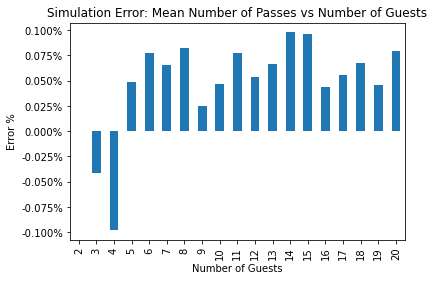

In [8]:
if os.path.exists('./output/analytical_mean_passes_and_inefficency.csv'):
    agg_analytical_uncond_all = pd.read_csv('./output/analytical_mean_passes_and_inefficency.csv')
    df_compare_uncod_all = pd.merge(
        agg_rslts_uncond_mean_all.drop(columns = ['inefficiency']),
        agg_analytical_uncond_all.drop(columns = ['inefficiency']), 
        on = ['n_guests'],
        how ='outer',
        suffixes=['_sim', '_theory']
    )
    df_compare_uncod_all['mean_number_passes_pct_error'] = (
        1 - df_compare_uncod_all['mean_number_passes_sim'] / df_compare_uncod_all['mean_number_passes_theory']
    )
    
    # write comparison to file
    df_compare_all.to_csv('./output/analytical_vs_sim_mean_passes.csv')    
    
    # Mean number of Passes agreement with theory
    fig, ax = plt.subplots(facecolor = 'w')
    df_compare_uncod_all.plot.bar(x = 'n_guests', y = 'mean_number_passes_pct_error', 
                                  ax=ax, legend=False)
    ax.set_title('Simulation Error: Mean Number of Passes vs Number of Guests')
    ax.set_xlabel('Number of Guests')
    ax.set_ylabel('Error %')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))